---
title: "many models workflows in python i"
subtitle: |
  a tidymodels workflow in python using list columns in pandas dataframes
date: "2020-08-25"
date-modified: "2024-04-06"
jupyter: manymodels
categories: [python, workflow, tidymodels]
execute: 
    enabled: false
---

This summer I worked on my first substantial research project in Python. I've used Python for a number of small projects before, but this was the first time that it was important for me to have an efficient workflow for working with many models at once. In R, I spend almost all of my time using a 'many models' workflow that leverages list-columns in `tibble`s and a hefty amount of `tidyverse` manipulation. It's taken me a while to find a similar workflow in Python that I like, and so I'm documenting it here for myself and other parties who might benefit.

This post demonstrates how to organize models into dataframes for exploratory data analysis, and discusses why you might want to do this. In a future blog post I will show how to extend the basic workflow I present here to handle sample splitting, custom estimators, and parallel processing.

## Interlude for Pythonistas: many models workflows

The many models workflow is an extension of the 'split-apply-combine' workflow, a largely functional approach to data manipulation implemented in `dplyr` and `pandas`. The essential ideas of 'split-apply-combine' are articulated nicely in Hadley Wickham's short and easy to read [paper](https://www.jstatsoft.org/article/view/v040i01/v40i01.pdf), which I strongly encourage you to read. I assume you are comfortable with this general idea, which largely facilitates natural ways to compute descriptive statistics from data, and have some experience applying these concepts in either `dplyr`, `pandas`, or SQL.

Several years ago, this idea evolved: what if, instead of computing descriptive statistics, we wanted to compute more complicated estimands, while leveraging the power of grouped operations? Hadley's solution, which has proven very fruitful and served as the underlying idea for `tidymodels`, `tidyverts`, and several other modeling frameworks, is to put model objects themselves into dataframes. Hadley [presented](https://www.youtube.com/watch?v=rz3_FDVt9eg) on this idea, and also wrote about it in the [many models chapter](https://r4ds.had.co.nz/many-models.html) of *R for Data Science* and it has turned out to be quite fruitful.

## Why is putting model objects in dataframes a good idea?

The simple answer is that it keeps information about your models from drifting apart, as it tends to do otherwise.

My exploratory modeling often ends up looking something like this:

-   I want to compare models across a range of hyperparameter values. Often there are several distinct hyperparameters to consider at once[^1].

-   I want to look at many different properties of the model. As a contrived example, I might want to look at AIC, BIC, $R^2$ and RMSE for all my models[^2].

-   I want to quick create plots to compare these models, and am probably using a plotting libraries expects data in data frames

[^1]: It often makes sense to store hyperparameters in dicts in Python. This means you can't easily store model objects in dicts, because `model_store[hyperparameters] = my_model_object` gets all fussy because the hyperparameter dictionary isn't hashable.

[^2]: One natural approach here would be to have a list of model objects, a list of AIC values, a list of BIC values, etc. Now you run into an indexing issue where you have to figure out which index corresponds to a given model and keeping track of a bunch of maps like this. A natural solution is to say force all the indexes to match up -- everything with index 0 should correspond to the first model. Congratulations, you've just invented a data frame.

Anyway it turns out that dataframes handle this use case super well, provided we have some helpers. The overall workflow will look like this:

1.  **Specifying models to fit**: We organize a dataframe so that each row of the dataframe corresponds to one model we want to fit. For example, a single row of the dataframe might correspond to a single set of hyperparameter values, or a subset of the data.

2.  **Iterative model fitting**: We create a new column in the dataframes that holds fit models.

3.  **Iterative estimate extraction**: We extract information we want from the fits into new data frame columns, and then manipulate this data with our favorite dataframe or plotting libraries.

Note that steps (2) and (3) require iteration over many models. In functional languages, `map`-style operations are a natural (and easily parallelizable!) way to do this; in Python we can use list-comprehensions.

Another innovation in this workflow came from standardizing step (3), where we extract information from the models into a new column of the dataframe. A big issue that we can run into here is that when we extract information from the model object, it can have an inconvenient type that is hard to put in a dataframe column. This may seem esoteric but it turns out to matter a lot more than you'd expect.

David Robinson in his `broom` package proposed a solution that is increasingly the standard within the R community[^3]. The idea is to create special getter methods for model objects that always return information in consistently formatted data frames. For each model object, we get a data frame with information. Since there are many model objects, we end up with a column of dataframes, which we then flatten.

[^3]: I am currently the `broom` maintainer.

There has been a lot of pushback around the idea of a column of dataframes with the Python community, largely on the basis that it is not a performant data structure[^4]. This misses the point. The compute time in these workflows comes from model fitting, and afterwards we just want to keep track of things[^5].

[^4]: Another big selling point of dataframes is vectorized operations on the columns. However, you can't vectorize operations on model objects, and this leads to code that has to perform vectorize explicitly rather than letting dataframe libraries handle it implicitly. There is a definitely a learning curve for new users here but I'm pretty convinced it's worth it.

[^5]: Another complaint that you might have as a Pythonista is that you should construct a custom model object to handle all this model tracking. I'm actually pretty curious about this and would love to hear ideas. My suspition is that the big challenge is coming up with a sufficiently general framework to accommodate widely varying use cases.

Anyway, there's a lot more to say about the workflow conceptually, but for now, it is time to show some code and see how things work in practice. For this post, I am going to recreate the analysis that Hadley does in his linked presentation above, which makes use of the [gapminder](https://pypi.org/project/gapminder/) data. The gapminder data consists of life expectancies for 142 counties, reported every 5 years from 1952 to 2007.

## Setting the scene

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

# you can download the gapminder csv file from my google drive
# https://drive.google.com/file/d/1pAgIKdsZPwYteQ2rfq14WrUtS23Tg4Lu/

gapminder = pd.read_csv('gapminder.csv')
gapminder

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106
...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623


To get a feel for the data, lets plot the life expectancy of each country over time, facetting by continent[^6].

[^6]: Aside: I have found plotting in Python to be a largely unpleasant experience. At this point, I've pretty much settled on `seaborn` as my go-to plotting library, and I use `sns.FacetGrid` for almost everything, even when I don't need facetting, because enough of my `ggplot2` intuition carries over that I can mostly get things done.

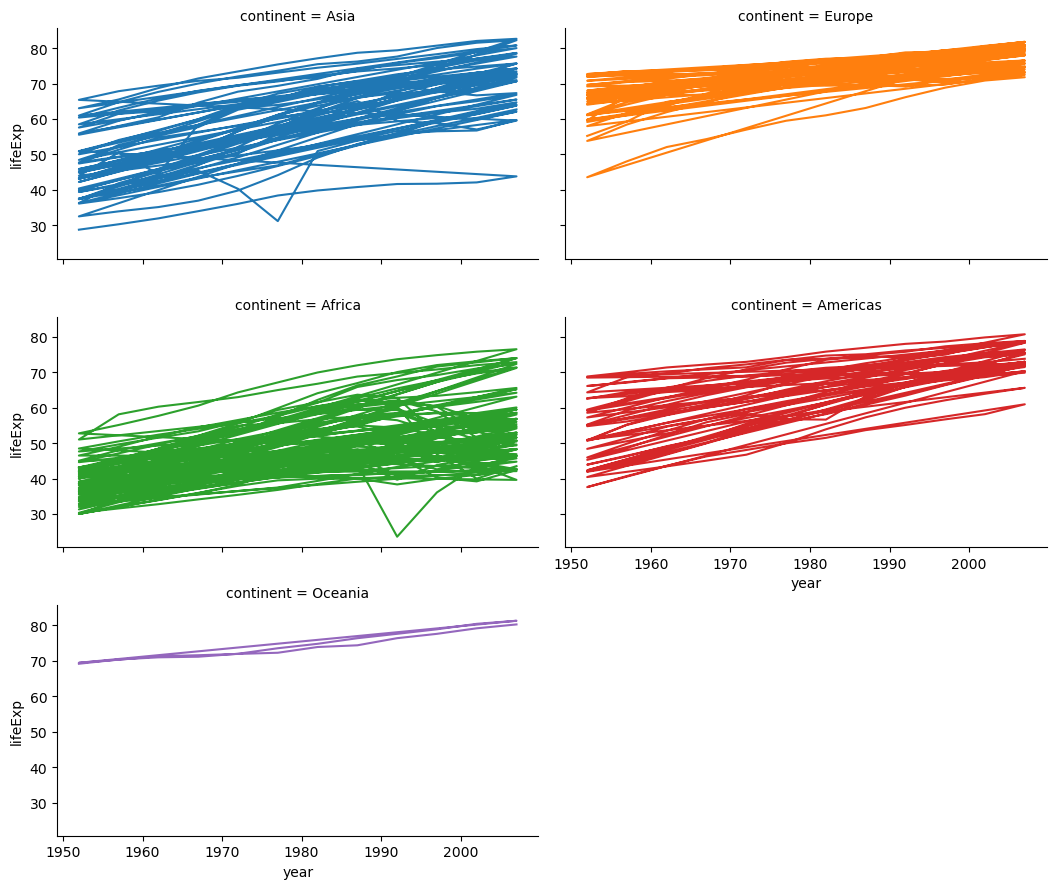

In [2]:
#| column: page
p = sns.FacetGrid(
    data=gapminder,
    hue='continent',
    col='continent',
    col_wrap=2,
    height=3,
    aspect=16/9
).map(plt.plot, 'year', 'lifeExp')

plt.show()

## Step 1: specifying models to fit

Following Hadley's presentation, suppose we would like to summarize the trend for each country by fitting a linear regression to the data from each country. So we have a correspondence 1 model \~ data from 1 country, and want to set up our data frame so that each row corresponds to data from a single country.

`groupby()` plus a list-comprehension handles this nicely, leveraging the fact that `gapminder.groupby('country')` is an iterable. In R, you could also use `group_by()` for this step, or additionally `nest()` or `rowwise()`, two `tidyverse` specification abstractions.

In [3]:
#| column: page
models = pd.DataFrame({
    # this works because grouped dataframes in pandas are iterable
    # and because you can pretty much treat series objects like
    # they are lists
    'data': [data for _, data in gapminder.groupby('country')],
})

models.index = [country for country, _ in gapminder.groupby('country')]

# the downside of putting weird stuff into pandas dataframes is that
# the dataframes print poorly
models

,data
Afghanistan,country continent year lifeExp ...
Albania,country continent year lifeExp pop ...
Algeria,country continent year lifeExp pop...
Angola,country continent year lifeExp pop ...
Argentina,country continent year lifeExp p...
...,...
Vietnam,country continent year lifeExp p...
West Bank and Gaza,country continent year life...
"Yemen, Rep.",country continent year lifeExp ...
Zambia,country continent year lifeExp po...


## Step 2: iterative model fitting

Now we need to do the actual model fitting. My preferred approach is to use list-comprehensions.

In [4]:
def country_model(df):
    return smf.ols('lifeExp ~ year', data=df).fit()

models['fit'] = [
    country_model(data)
    for _, data in gapminder.groupby('country')
]

One compelling advantage of this (effectively) functional approach to iteration over list-columns of models is that most of these computations are embarrassingly parallel, and map()-like operations are often very easy to parallelize.

An alternative approach here is to use `DataFrame.apply()`. However, I have found the `Series.apply()` and `DataFrame.apply()` methods to be hard to reason about when used together with list-columns, and so I recommend avoiding them.

In [5]:
# the pandas apply() approach

# models = (
#     gapminder
#     .groupby('country')
#     .apply(country_model)
#     .to_frame(name='fit')
# )

## Step 3: iterative information extraction

Now that we've fit all of our models, we can extract information from them. Here I'll define some helper functions very much in the spirit of `broom`. When you don't own the model classes you're using, you pretty much have to write extractor functions to do this; see Michael Chow's excellent [blog post](https://mchow.com/posts/2020-02-24-single-dispatch-data-science/) showing how to handle this in an elegant way.

Even if you do own the model objects you're using, I recommend extractor functions over class methods. This is because, during EDA, you typically fit some expensive models once, and then repeatedly investigate them--you can modify an extractor function and use it right away, but if you modify a method for a model class, you'll have to refit all the model objects. This leads to slow iteration.

In [6]:
# ripped directly from michael chow's blog post!!
# go read his stuff it's very cool!
def tidy(fit):
    from statsmodels.iolib.summary import summary_params_frame
    tidied = summary_params_frame(fit).reset_index()
    rename_cols = {
        'index': 'term', 'coef': 'estimate', 'std err': 'std_err',
        't': 'statistic', 'P>|t|': 'p_value',
        'Conf. Int. Low': 'conf_int_low', 'Conf. Int. Upp.': 'conf_int_high'
    }
    
    return tidied.rename(columns = rename_cols)

def glance(fit):
    return pd.DataFrame({
        'aic': fit.aic,
        'bic': fit.bic,
        'ess': fit.ess, # explained sum of squares
        'centered_tss': fit.centered_tss,
        'fvalue': fit.fvalue,
        'f_pvalue': fit.f_pvalue,
        'nobs': fit.nobs,
        'rsquared': fit.rsquared,
        'rsquared_adj': fit.rsquared_adj
    }, index=[0])

# note that augment() takes 2 inputs, whereas tidy() and glance() take 1
def augment(fit, data):
    df = data.copy()
    
    if len(df) != fit.nobs:
        raise ValueError("`data` does not have same number of observations as in training data.")
    
    df['fitted'] = fit.fittedvalues
    df['resid'] = fit.resid
    return df

We check the helper functions by seeing if they work on a single model object before working with the entire list-column of models.

In [7]:
#| column: page
tidy(models.fit[0])

/tmp/ipykernel_125615/476014805.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tidy(models.fit[0])


,term,estimate,std_err,statistic,p_value,conf_int_low,conf_int_high
0,Intercept,-507.534272,40.484162,-12.536613,1.934055e-07,-597.738606,-417.329937
1,year,0.275329,0.020451,13.462890,9.835213e-08,0.229761,0.320896


In [8]:
#| column: page
glance(models.fit.iloc[0])

,aic,bic,ess,centered_tss,fvalue,f_pvalue,nobs,rsquared,rsquared_adj
0,40.69387,41.663683,271.006011,285.958116,181.24941,9.835213e-08,12.0,0.947712,0.942483


`augment()` actually takes two inputs, where one input is the model object, and the other is the training data used to fit that model object.

In [9]:
#| column: page
augment(models.fit.iloc[0], models.data.iloc[0])

,country,continent,year,lifeExp,pop,gdpPercap,fitted,resid
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,29.907295,-1.106295
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,31.283938,-0.951938
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,32.660582,-0.663582
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,34.037225,-0.017225
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,35.413868,0.674132
5,Afghanistan,Asia,1977,38.438,14880372,786.113360,36.790512,1.647488
6,Afghanistan,Asia,1982,39.854,12881816,978.011439,38.167155,1.686845
7,Afghanistan,Asia,1987,40.822,13867957,852.395945,39.543798,1.278202
8,Afghanistan,Asia,1992,41.674,16317921,649.341395,40.920442,0.753558
9,Afghanistan,Asia,1997,41.763,22227415,635.341351,42.297085,-0.534085


Now we are ready to iterate over the list-column of models. Again, we leverage list-comprehensions. For `tidy()` and `glance()` these comprehension are straightforward, but for `augment()`, which will consume elements from two columns at once, we will need to do something a little fancier. In R we could use `purrr::map2()` or `purrr::pmap()`, but the Pythonic idiom here is to use `zip()` together with tuple unpacking.

In [10]:
#| column: page
models['tidied'] = [tidy(fit) for fit in models.fit]
models['glanced'] = [glance(fit) for fit in models.fit]

models['augmented'] = [
    augment(fit, data)
    for fit, data in zip(models.fit, models.data)
]

**Note for R users**: In R the calls to `tidy()`, etc, would typically live inside a `mutate()` call. The `pandas` equivalent is `assign`, but `pandas` doesn't leverage non-standard evaluation and I typically don't use `assign()` unless I really want to leverage method chaining for some reason. Normally I save method chaining for data manipulation once I have a flat dataframe, and otherwise I operate entirely via list comprehensions.

Anyway, the print method garbles the hell out of our results but whatever.

In [11]:
#| column: page
models

,data,fit,tidied,glanced,augmented
Afghanistan,country continent year lifeExp ...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statistic...,aic bic ess centered_t...,country continent year lifeExp ...
Albania,country continent year lifeExp pop ...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statistic...,aic bic ess centered_...,country continent year lifeExp pop ...
Algeria,country continent year lifeExp pop...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statistic...,aic bic ess centered_...,country continent year lifeExp pop...
Angola,country continent year lifeExp pop ...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statistic...,aic bic ess centered_t...,country continent year lifeExp pop ...
Argentina,country continent year lifeExp p...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statistic ...,aic bic ess centered_ts...,country continent year lifeExp p...
...,...,...,...,...,...
Vietnam,country continent year lifeExp p...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statisti...,aic bic ess centered...,country continent year lifeExp p...
West Bank and Gaza,country continent year life...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statisti...,aic bic ess centered_...,country continent year life...
"Yemen, Rep.",country continent year lifeExp ...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statisti...,aic bic ess centered...,country continent year lifeExp ...
Zambia,country continent year lifeExp po...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statisti...,aic bic ess centered_t...,country continent year lifeExp po...


## Flattening the dataframe

Our final step before we can recreate Hadley's plots is to flatten or "unnest" the dataframe. `pandas` has no unnest method, but the following has served me well so far to unnest a single column. This will not play well with dataframes with MultiIndexes, which I recommend avoiding.

In [12]:
def unnest(df, value_col):
    lst = df[value_col].tolist()
    unnested = pd.concat(lst, keys=df.index)
    unnested.index = unnested.index.droplevel(-1)
    return df.join(unnested).drop(columns=value_col)

If we unnest just the `glance()` results we get:

In [13]:
#| column: page
glance_results = unnest(models, 'glanced')

# equivalently
glance_results = (
    models
    .pipe(unnest, 'glanced')
    
    # little bit of extra cleanup
    .reset_index()
    .rename(columns={'index': 'country'})
)

glance_results

,country,data,fit,tidied,augmented,aic,bic,ess,centered_tss,fvalue,f_pvalue,nobs,rsquared,rsquared_adj
0,Afghanistan,country continent year lifeExp ...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statistic...,country continent year lifeExp ...,40.693870,41.663683,271.006011,285.958116,181.249410,9.835213e-08,12.0,0.947712,0.942483
1,Albania,country continent year lifeExp pop ...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statistic...,country continent year lifeExp pop ...,52.298071,53.267884,400.445959,439.771289,101.829014,1.462763e-06,12.0,0.910578,0.901636
2,Algeria,country continent year lifeExp pop...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statistic...,country continent year lifeExp pop...,42.584427,43.554240,1158.583855,1176.087314,661.917086,1.808143e-10,12.0,0.985117,0.983629
3,Angola,country continent year lifeExp pop ...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statistic...,country continent year lifeExp pop ...,44.061857,45.031670,156.667858,176.464605,79.138182,4.593498e-06,12.0,0.887815,0.876596
4,Argentina,country continent year lifeExp p...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statistic ...,country continent year lifeExp p...,6.347866,7.317679,191.937384,192.791819,2246.366349,4.215567e-13,12.0,0.995568,0.995125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Vietnam,country continent year lifeExp p...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statisti...,country continent year lifeExp p...,42.414079,43.383892,1612.565329,1629.822069,934.455357,3.289412e-11,12.0,0.989412,0.988353
138,West Bank and Gaza,country continent year life...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statisti...,country continent year life...,52.287427,53.257240,1291.726331,1331.016795,328.763323,5.585089e-09,12.0,0.970481,0.967529
139,"Yemen, Rep.",country continent year lifeExp ...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statisti...,country continent year lifeExp ...,46.932773,47.902586,1310.527555,1335.675109,521.135193,5.868274e-10,12.0,0.981172,0.979290
140,Zambia,country continent year lifeExp po...,<statsmodels.regression.linear_model.Regressio...,term estimate std_err statisti...,country continent year lifeExp po...,72.117172,73.086985,13.053046,218.145441,0.636447,4.435318e-01,12.0,0.059836,-0.034180


Now we could ask a question like "what countries seem to have the most linear trends in life expectancy?" and use R-squared as a measure of this.

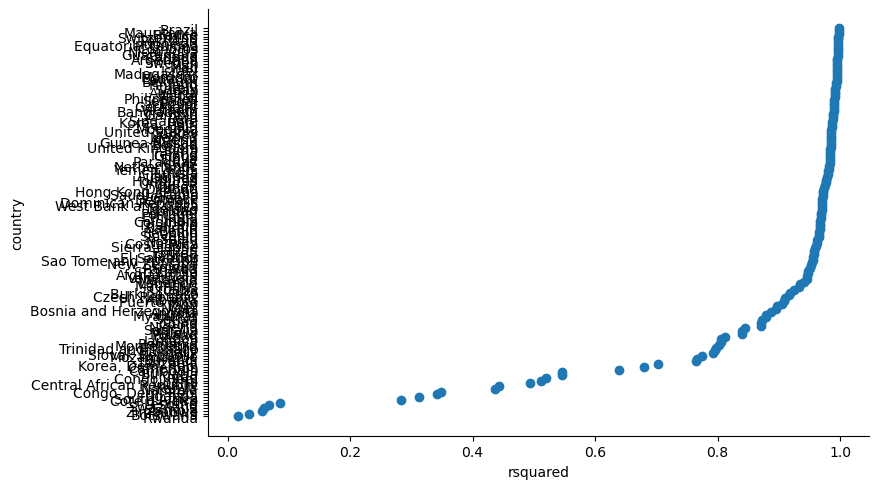

In [14]:
#| column: page
p = (
    sns.FacetGrid(
        data=glance_results.sort_values('rsquared'),
        height=5,
        aspect=16/9
    )
    .map(plt.scatter, 'rsquared', 'country')
)
plt.show()

Okay so this plot is awful but I don't have the patience at the moment to make it better. We could also look at residuals for individual fits to inspect them for any patterns that might indicate systematic error.

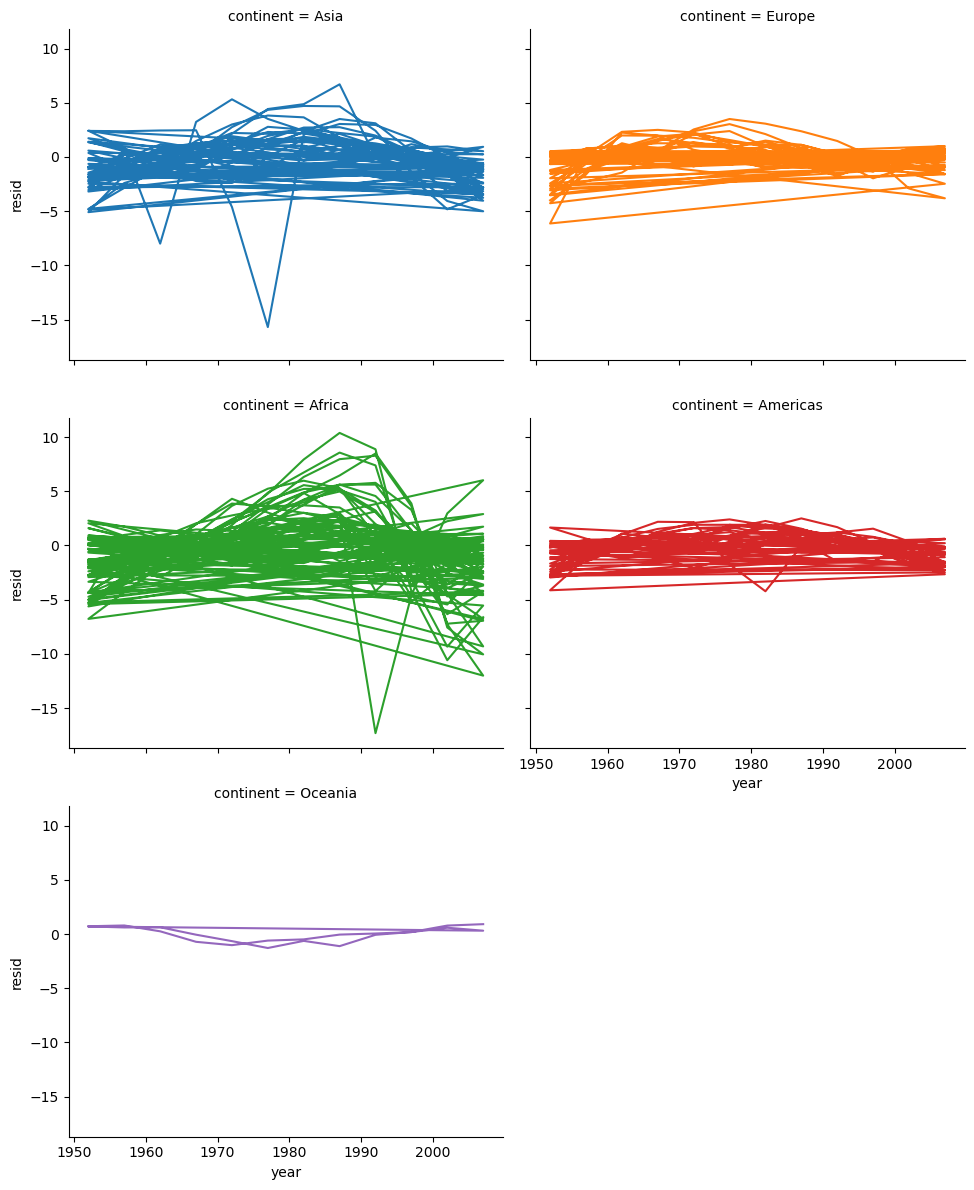

In [15]:
#| column: page
augment_results = unnest(models, 'augmented')

p = (
    sns.FacetGrid(
        data=augment_results,
        col='continent', 
        col_wrap=2,
        hue='continent',
        height=4, aspect=16/13)
    .map(plt.plot, 'year', 'resid')
)
plt.show()

It would be nice to add smooths by continent as Hadley does but again I don't have the patience or masochistic urge to figure out how to do that. In any case, there are some clear trends in the residuals, especially for Africa, which suggest that some further modeling is a good idea.

## The end

So that's the basic idea behind the many models workflow. Note that we've been working at a fairly low-level of abstraction. This means you have a lot of control over what happens (good for research and EDA), but have to write a lot of code. If you're just fitting prediction models and the only thing you want to do is compare risk estimates, you can save time and effort by using `sklearn`'s `GridSearchCV` object.

One final note: in Hadley's gapminder example we iterate over disjoint data sets. In practice I do this extremely rarely. Much more often I find myself iterating over `(train, test)` pairs, or hyperparameters, or both at once. This hyperparameter optimization over many CV-folds workflow is more complex than the simple example here, but still fits nicely into the many models workflow I've described here. I'll demonstrate how to do that in a followup post.